## Imports

In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
from PIL import Image
import glob
import shutil

# Configure plot display settings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

import tarfile
from tqdm.notebook import tqdm
from IPython import display

# Weights and Biases related imports
import wandb
from wandb.integration.keras import WandbMetricsLogger
from wandb.integration.keras import WandbModelCheckpoint

# Custom modules
from models.local_discriminator import get_local_discriminator
from models.generator import get_generator
from models.GAN import GAN
from utils.gan_functions import GANMonitor
from utils.image_processing import display_image, apply_random_patches, extract_and_preprocess_images, plot_test_images


2.16.1


In [2]:
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: leonardo-polverari (uniboc). Use `wandb login --relogin` to force relogin


True

## Hyperparams

In [3]:
# Define training hyperparameters
# SIAMO A 60!
epochs = 2
learning_rate = 5e-5
batch_size = 32
image_height = 256
image_width = 256
channels = 1
patch_shape = (64, 64, channels)
patch_size = 8
patch_dim = patch_size * patch_size 
# Input image dimensions
input_shape = (image_height, image_width, channels)
# Total number of patches
num_patches = (input_shape[0] // patch_size) ** 2
# Dimensionality of embedding space
embedding_dim = 64
# Number of attention heads
num_heads = 6
# Dimension of feed-forward network
ff_dim = 96
# Number of Transformer blocks
transformer_layers = 5
# Units in MLP head layers
mlp_head_units = [512, 100]
# Dropout rate for regularisation
dropout_rate = 0.1
# Stochastic depth rate for regularisation
stochastic_depth_rate = 0.1
# Dimension of a patch
patch_dim = patch_size * patch_size * input_shape[2]
latent_dim = 128
train_size = 30000
test_size = 1000

# Print current parameters
print(f"Input shape:          {input_shape}")
print(f"Patch size:           {patch_size}")
print(f"Number of patches:    {num_patches}")
print(f"Embedding dimension:  {embedding_dim}")
print(f"Number of heads:      {num_heads}")
print(f"Feed-forward dimension: {ff_dim}")
print(f"Number of Transformer layers: {transformer_layers}")
print(f"MLP head units:       {mlp_head_units}")
print(f"Patch dimension:      {patch_dim}")


# Print current parameters
print(f"Parameters defined:\n"
      f"  epochs:        {epochs:>8}\n"
      f"  learning_rate: {learning_rate:>8.1e}\n"
      f"  batch_size:    {batch_size:>8}\n"
      f"  image_height:  {image_height:>8}\n"
      f"  image_width:   {image_width:>8}\n"
      f"  channels:      {channels:>8}\n"
      f"  patch_shape:   {patch_shape}\n"
      )

Input shape:          (256, 256, 1)
Patch size:           8
Number of patches:    1024
Embedding dimension:  64
Number of heads:      6
Feed-forward dimension: 96
Number of Transformer layers: 5
MLP head units:       [512, 100]
Patch dimension:      64
Parameters defined:
  epochs:               2
  learning_rate:  5.0e-05
  batch_size:          32
  image_height:       256
  image_width:        256
  channels:             1
  patch_shape:   (64, 64, 1)



## Stream Data

### Stream Whole Picture

In [4]:
# Path to your tar file
tar_path = 'data\my_artbench_10_imagefolder_split.tar'

# Convert the generator into a TensorFlow Dataset
image_dataset = tf.data.Dataset.from_generator(
    lambda: extract_and_preprocess_images(tar_path, patch_shape, image_height = 256, image_width = 256, channels = 1),
    output_signature=(
        tf.TensorSpec(shape=(image_height, image_width, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(image_height, image_width, 1), dtype=tf.float32),
    )
)

test_dataset = tf.data.Dataset.from_generator(
    lambda: extract_and_preprocess_images(tar_path, patch_shape, return_inverse=True),
    output_signature=(
        tf.TensorSpec(shape=(image_height, image_width, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(image_height, image_width, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(image_height, image_width, 1), dtype=tf.float32)
    )
)

# 60,000 images
image_dataset = image_dataset.shuffle(buffer_size = 1000, seed = 42)

# 40,000 for training
train_data = image_dataset.skip(test_size).take(train_size)

# 10,000 for testing
test_data = test_dataset.take(test_size)

image_dataset = image_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_data = train_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.AUTOTUNE)


input_shape = train_data.element_spec[0].shape[1:]
print(input_shape)

(256, 256, 1)


In [5]:
# Create an instance of the GAN model with specified discriminator, generator, and latent dimension
gan = GAN(
    local_discriminator=get_local_discriminator(input_shape),
    generator=get_generator(input_shape, channels),
    n_discriminator_updates=3
)

# Compile the GAN model with Adam optimisers for both discriminator and generator
gan.compile(
    local_optimizer=tfk.optimizers.AdamW(learning_rate=learning_rate, beta_1=0.5, beta_2=0.999),
    g_optimizer=tfk.optimizers.Adam(learning_rate=learning_rate, beta_1=0.5, beta_2=0.999),
    mae_weight=1.5,
    local_weight=1,
)

## Reload Model After Compiling

In [6]:
import os
if os.path.exists('models\latest.weights.h5'):
    print('Weights Found')
    gan.load_weights('models\latest.weights.h5')
    print('Weights Loaded')

Weights Found
Weights Loaded


## Training

In [7]:
test_batch = next(iter(test_data))

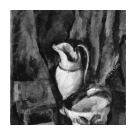

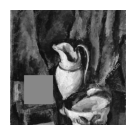

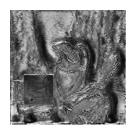

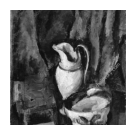

: 

: 

In [8]:
n_img = 0
n_imgs = 5
for i in range(n_img, n_img + n_imgs):
    gen_img = gan.generator(test_batch[0] * test_batch[1])[i]
    display_image(test_batch[0][i] * 0.5 + 0.5)
    display_image(test_batch[0][i] * (0.5 + 0.5 ) * test_batch[1][i])
    display_image(gen_img * (0.5 + 0.5 ))
    display_image((gen_img*(1-test_batch[1][i]) + test_batch[0][i] * test_batch[1][i]) * (0.5 + 0.5 ))

# ricorda di reimportare weights (epoche per ora: 3)

In [ ]:
# Train the GAN model on the dataset with specified parameters
run = wandb.init(
    project = "gan_ghog",
)

history = gan.fit(
    train_data,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[
        GANMonitor(name='gan_ghog', gray=True, test_images = test_batch),
        
        WandbMetricsLogger(log_freq=10),
        # WandbModelCheckpoint(filepath="models/gan_ghog.keras")
    ],
).history